In [2]:
import os
import cv2
import numpy as np
from tqdm import tqdm

In [42]:
REBUILD_DATA=False
DIR="/Users/piroova/Documents/Personal/Machine Learning/DataSets/PetImages/"

In [39]:
class DogsVSCades():
    IMG_SIZE=50
    CATS=DIR+"Cat"    
    DOGS=DIR+"Dog"
    LABELS={CATS:0, DOGS:1}
    traning_data=[]
    catcount=0
    dogcount=0
    
    
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                    path=os.path.join(label,f)
                    img=cv2.imread(path,cv2.IMREAD_GRAYSCALE)
                    img=cv2.resize(img,(self.IMG_SIZE,self.IMG_SIZE))
                    self.traning_data.append([np.array(img),np.eye(2)[self.LABELS[label]]]) #convert to one hot vector > eye                
                    if label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1
                except Exception as e:
#                     print(e.args)
                    pass
        np.random.shuffle(self.traning_data)
        np.save("training_data.npy",self.traning_data)
        print("Cats:", self.catcount)
        print("Dogs:", self.dogcount)
                


In [40]:
if REBUILD_DATA:
    dogsvscats = DogsVSCades()
    dogsvscats.make_training_data()

  1%|          | 77/12501 [00:00<00:16, 764.15it/s]

/Users/piroova/Documents/Personal/Machine Learning/DataSets/PetImages/Cat


  0%|          | 45/12501 [00:00<00:27, 449.10it/s]

/Users/piroova/Documents/Personal/Machine Learning/DataSets/PetImages/Dog


100%|██████████| 12501/12501 [00:33<00:00, 372.62it/s]
/Users/piroova/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Cats: 12476
Dogs: 12470


In [41]:
training_data=np.load("training_data.npy",allow_pickle=True)

In [43]:
print(len(training_data))

24946


In [45]:
print(training_data[1])

[array([[210, 122, 124, ..., 176, 173, 171],
       [218, 130, 125, ..., 176, 173, 171],
       [222, 131, 130, ..., 176, 176, 172],
       ...,
       [211, 214, 214, ...,  85, 153, 145],
       [208, 212, 212, ...,  29, 147, 143],
       [203, 206, 212, ...,  41,  47, 132]], dtype=uint8)
 array([0., 1.])]


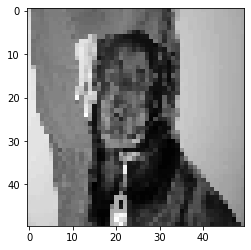

In [48]:
import matplotlib.pyplot as plt
plt.imshow(training_data[1][0],cmap="gray")
plt.show()

In [49]:
# cnn
import torch
import torch.nn as nn
import torch.nn.functional as F  

In [52]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        self.fc1=nn.Linear(128,512)
        self.fc2=nn.Linear(512,2)
        
    def forwrad(self,x):
        x=F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x=F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        x=F.max_pool2d(F.relu(self.conv3(x)),(2,2))
        x=x.view(-1,128)
        x=F.relu(self.fc1(x))
        x=self.fc2(X)
        return F.softmax(x,dim=1)
        

In [68]:
net=Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=128, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


In [63]:
import torch.optim as optim

optimizer=optim.Adam(net.parameters(),lr=0.001)
loss_function=nn.MSELoss()

In [64]:
X=torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X=X/255.0
y=torch.Tensor([i[1] for i in training_data])

VAL_PCT=0.1
val_size=int(len(X)*VAL_PCT)
print(val_size)

2494


In [65]:
train_X=X[:-val_size]
train_y=y[:-val_size]
test_X=X[-val_size:]
test_y=y[-val_size:]
print(len(train_X))
print(len(test_X))

22452
2494


In [70]:
BATCH_SIZE=100
EPOCHS=1

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X),BATCH_SIZE)):
        # print(i,i+BATCH_SIZE)
        batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
        batch_y = train_y[i:i+BATCH_SIZE]

        net.zero_grad()

        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()    # Does the update

    print(f"Epoch: {epoch}. Loss: {loss}")



  0%|          | 0/225 [00:00<?, ?it/s]


NotImplementedError: 

In [71]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:50] ..for now just to dev
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, 50, 50))[0]  # returns a list, 
        predicted_class = torch.argmax(net_out)

        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total, 3))


  0%|          | 0/225 [00:00<?, ?it/s]


NotImplementedError: 